In [6]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class InfectionSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(os.path.join(root_dir, 'images'))
        self.masks = os.listdir(os.path.join(root_dir, 'infection masks'))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'images', self.images[idx])
        mask_name = os.path.join(self.root_dir, 'infection masks', self.masks[idx])
        image = Image.open(img_name)
        mask = Image.open(mask_name)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask
        

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_dataset = InfectionSegmentationDataset(root_dir='/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = InfectionSegmentationDataset(root_dir='/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

test_dataset = InfectionSegmentationDataset(root_dir='/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [3]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

def resnet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels)
    )

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = resnet_block(1, 64)
        self.dconv_down2 = resnet_block(64, 128)
        self.dconv_down3 = resnet_block(128, 256)
        self.dconv_down4 = resnet_block(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

    

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1)
model = model.to(device)
# Loss function: Binary Cross Entropy
criterion = nn.BCEWithLogitsLoss()
# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [4]:
from tqdm import tqdm

from tqdm import tqdm
def train(model, train_loader, valid_loader, criterion, optimizer, n_epochs=10):
    loss_train = []
    loss_valid = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        
        loss_train.append(running_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss/len(train_loader)}")
        torch.save(model.state_dict(), 'last.pth')
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                # Plot the training and validation loss

            loss_valid.append(running_loss/len(valid_loader))
            print(f"Validation Loss: {running_loss/len(valid_loader)}")
    return loss_train, loss_valid

In [12]:
loss_train, loss_valid = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=50)
torch.save(model.state_dict(), 'model.pth')

100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 1/50 - Loss: 0.3150275441070483
Validation Loss: 0.2516521533667031


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 2/50 - Loss: 0.2385240739507225
Validation Loss: 0.22833104772587953


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


Epoch 3/50 - Loss: 0.21218778071485364
Validation Loss: 0.5678300554469481


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 4/50 - Loss: 0.20660970164982545
Validation Loss: 0.18945090801028883


100%|██████████| 233/233 [00:51<00:00,  4.49it/s]


Epoch 5/50 - Loss: 0.1925138056022415
Validation Loss: 0.23544171199960223


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 6/50 - Loss: 0.1887795823134578
Validation Loss: 0.1839820982541068


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 7/50 - Loss: 0.18307432375624455
Validation Loss: 0.2278989068532394


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 8/50 - Loss: 0.17019066224154486
Validation Loss: 0.1472655354162394


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 9/50 - Loss: 0.1576919588280338
Validation Loss: 0.20345899892055383


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 10/50 - Loss: 0.15347497817528605
Validation Loss: 0.1965829171871735


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 11/50 - Loss: 0.1518487030152599
Validation Loss: 0.13297846294560675


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 12/50 - Loss: 0.14368502642207903
Validation Loss: 0.1316551890666202


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 13/50 - Loss: 0.14343790434972412
Validation Loss: 0.1527234290615987


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 14/50 - Loss: 0.1403717013004
Validation Loss: 0.12988864011683707


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 15/50 - Loss: 0.1360575643731801
Validation Loss: 0.12485406042660697


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 16/50 - Loss: 0.13455729586244142
Validation Loss: 0.14099735021591187


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 17/50 - Loss: 0.13020880286913572
Validation Loss: 0.13660465761766596


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


Epoch 18/50 - Loss: 0.13102710365353737
Validation Loss: 0.11957081634614428


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


Epoch 19/50 - Loss: 0.12227913270436643
Validation Loss: 0.13071181258912815


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 20/50 - Loss: 0.12500902153391694
Validation Loss: 0.15463822600194962


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 21/50 - Loss: 0.12102928079760637
Validation Loss: 0.12297505973759344


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 22/50 - Loss: 0.11956747084088591
Validation Loss: 0.11686808173939334


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


Epoch 23/50 - Loss: 0.11877205798426411
Validation Loss: 0.11688748178845745


100%|██████████| 233/233 [00:51<00:00,  4.49it/s]


Epoch 24/50 - Loss: 0.11631147000666851
Validation Loss: 0.1291643378593154


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 25/50 - Loss: 0.11330250242940858
Validation Loss: 0.119535109375493


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 26/50 - Loss: 0.11053306273636389
Validation Loss: 0.11691235940335161


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 27/50 - Loss: 0.10849657843425038
Validation Loss: 0.12318463206796323


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 28/50 - Loss: 0.1067802160019015
Validation Loss: 0.11433354020118713


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 29/50 - Loss: 0.10262131085019767
Validation Loss: 0.13050856201325434


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


Epoch 30/50 - Loss: 0.10696999063563449
Validation Loss: 0.11290290939100718


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 31/50 - Loss: 0.10129552574372598
Validation Loss: 0.10733681007967157


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 32/50 - Loss: 0.09814203883892988
Validation Loss: 0.1105574308815649


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 33/50 - Loss: 0.09831167504894887
Validation Loss: 0.1148387871808925


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 34/50 - Loss: 0.09837552598105992
Validation Loss: 0.1088055959444935


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 35/50 - Loss: 0.09846723110059301
Validation Loss: 0.11282621993351791


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 36/50 - Loss: 0.09073935871216361
Validation Loss: 0.13036492883653963


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 37/50 - Loss: 0.08655867457006111
Validation Loss: 0.12406751904952323


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 38/50 - Loss: 0.08315894604049015
Validation Loss: 0.11366477217209542


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 39/50 - Loss: 0.0780777900355824
Validation Loss: 0.12351061138561216


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 40/50 - Loss: 0.07833490864465677
Validation Loss: 0.13068789584656892


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 41/50 - Loss: 0.07313670168426926
Validation Loss: 0.1285101597086858


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 42/50 - Loss: 0.07169450195945895
Validation Loss: 0.12455657945346024


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 43/50 - Loss: 0.06685362748258103
Validation Loss: 0.12749688781924168


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 44/50 - Loss: 0.061854663356946775
Validation Loss: 0.11914158587233495


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 45/50 - Loss: 0.06145857214575929
Validation Loss: 0.13982940673575564


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 46/50 - Loss: 0.058028622406490885
Validation Loss: 0.13125608785677764


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 47/50 - Loss: 0.054551085657060405
Validation Loss: 0.14196275161989666


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 48/50 - Loss: 0.05655807327846857
Validation Loss: 0.12668822510010105


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 49/50 - Loss: 0.05059793123040077
Validation Loss: 0.14125409570790953


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 50/50 - Loss: 0.051680007541768026
Validation Loss: 0.13325470149264498


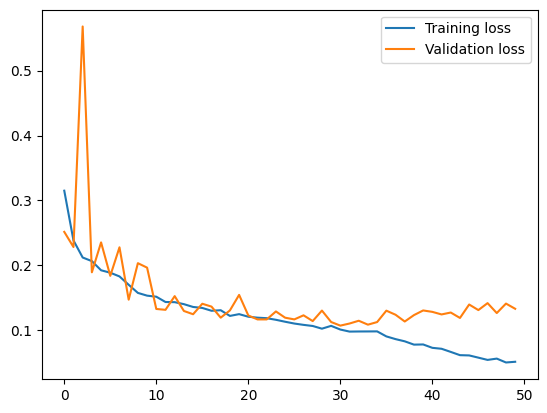

In [13]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()



In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")

Mean Absolute Error: 16.321765899658203
IoU: 0.13897233966284306


In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)
model.load_state_dict(torch.load("model.pth", map_location = device))

<All keys matched successfully>

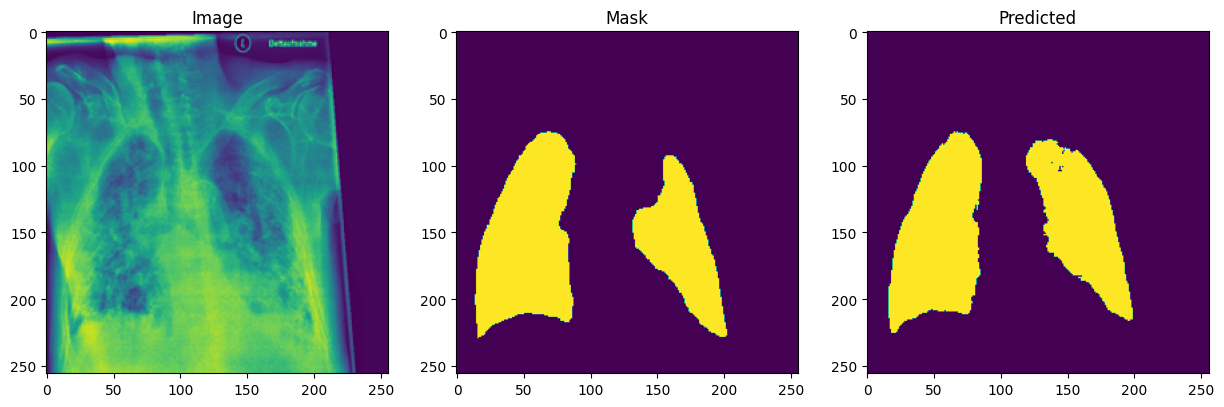

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


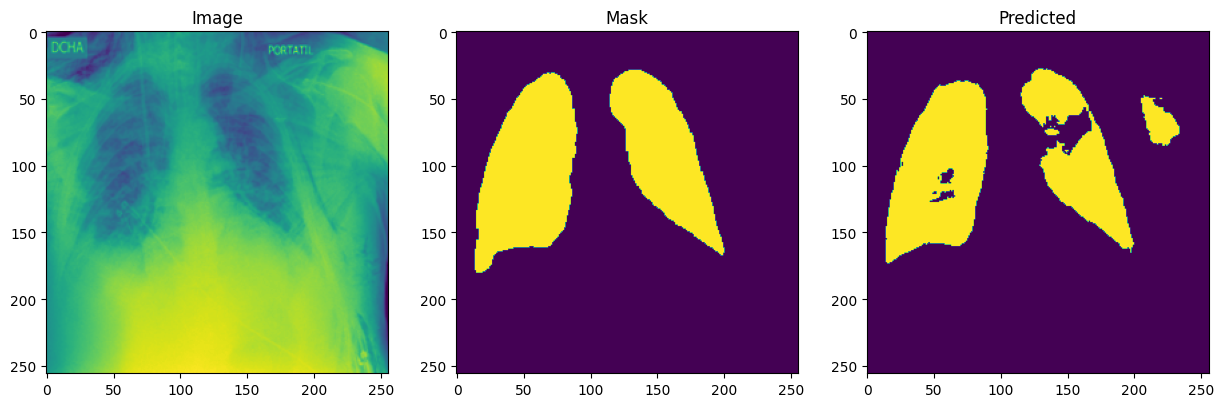

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


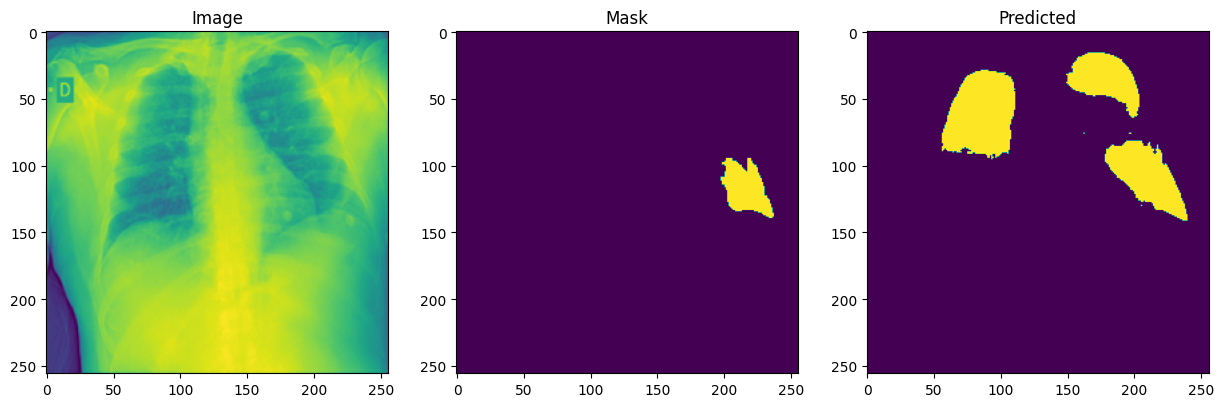

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


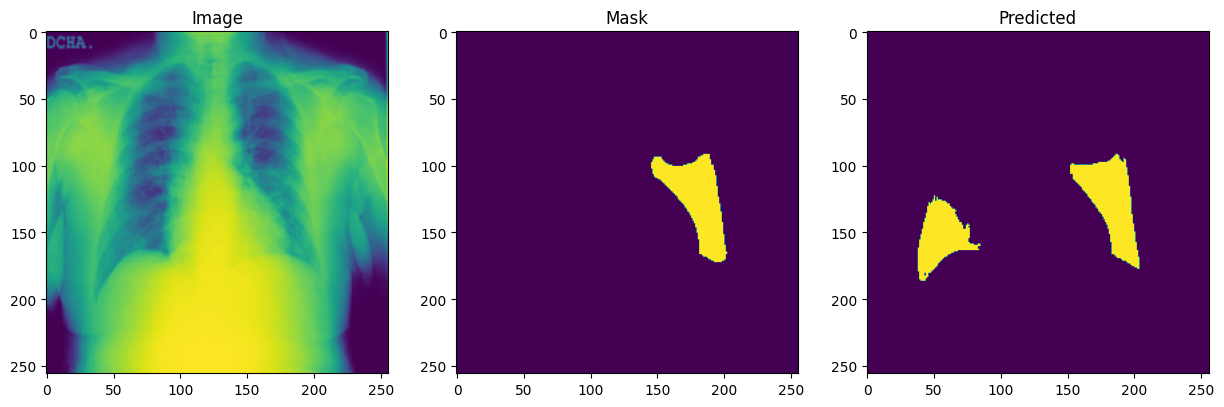

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


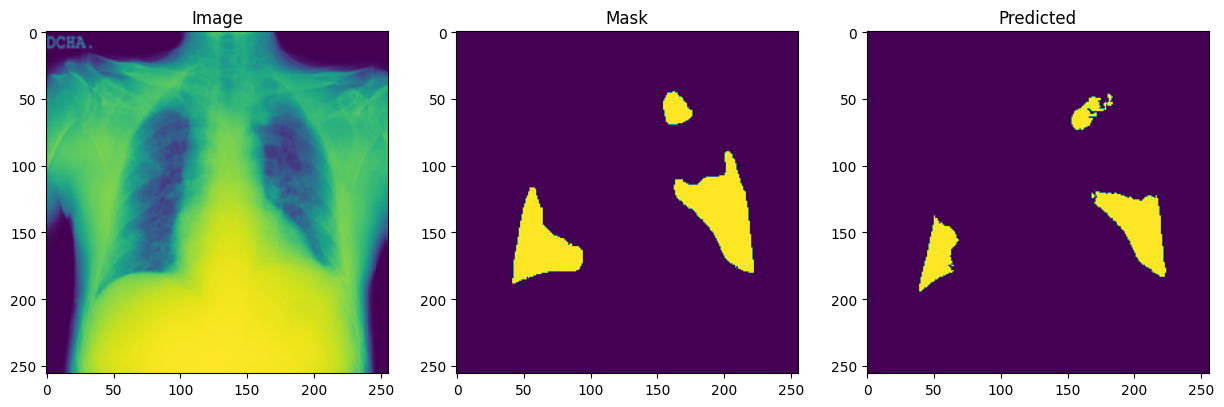

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


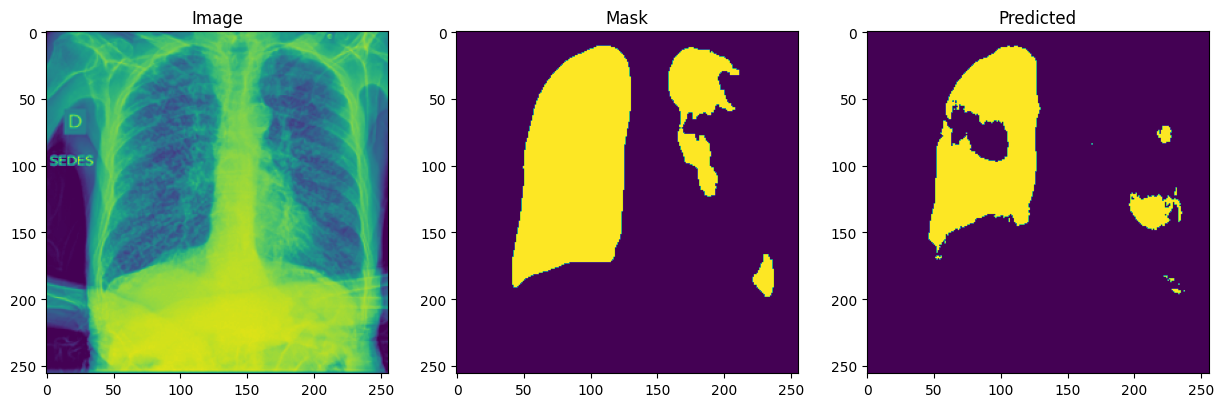

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


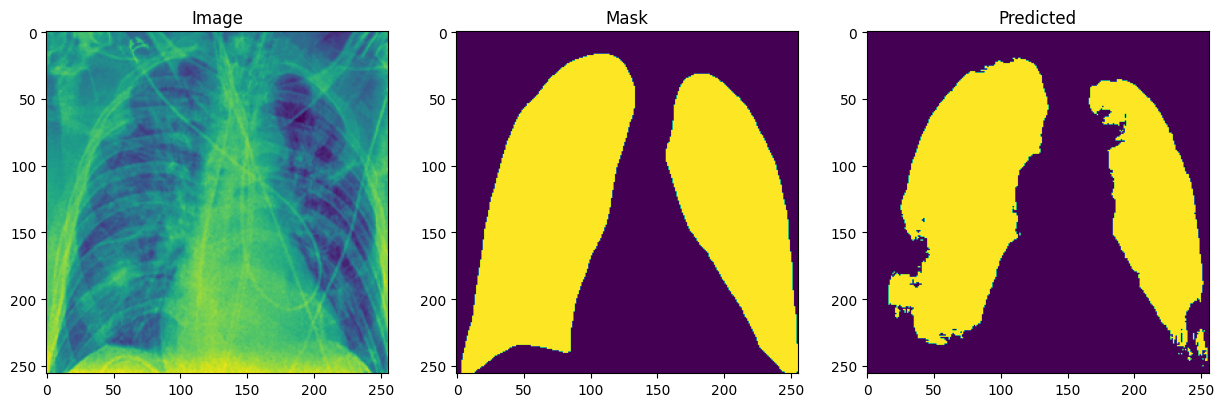

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


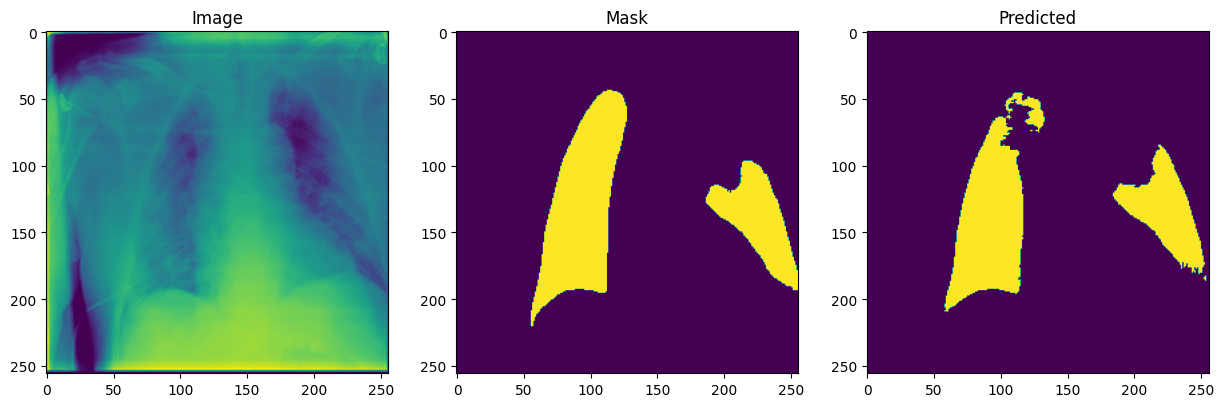

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


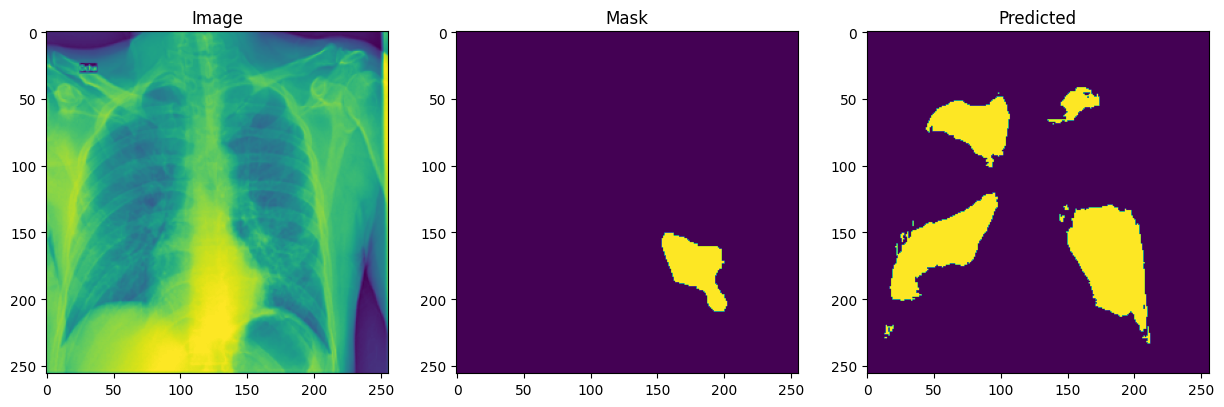

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


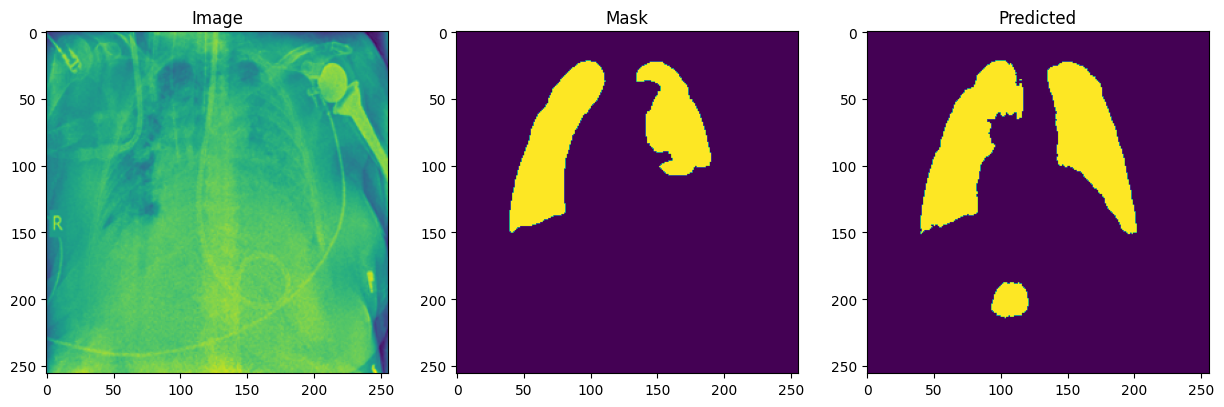

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [14]:
import matplotlib.pyplot as plt

for image_idx in range(100, 110):
    image, mask = test_dataset[image_idx]
    output = model(image.unsqueeze(0).to(device)).to(device)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(image.permute(1, 2, 0))  # Display an image
    axs[0].set_title('Image')

    axs[1].imshow(mask[0])  # Display an image
    axs[1].set_title('Mask')

    axs[2].imshow(output[0, 0].cpu().detach().numpy()>0.15)  # Display an image
    axs[2].set_title('Predicted')

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [17]:
class IoULoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(IoULoss, self).__init__()
        self.eps = eps

    def forward(self, inputs, targets):
        # Compute intersection
        intersection = (inputs * targets).sum()
        # Compute union
        total = (inputs + targets).sum()
        union = total - intersection 

        iou = (intersection + self.eps) / (union + self.eps)
        return 1 - iou
    
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.iou = IoULoss()

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.iou(inputs, targets)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_combine_bce_iou = UNet(n_class=1).to(device)
# Now use IoU as the loss function
criterion = CombinedLoss()
# Optimizer: Adam
optimizer = torch.optim.Adam(model_combine_bce_iou.parameters(), lr=0.001)

In [18]:
loss_train, loss_valid = train(model_combine_bce_iou, train_loader, val_loader, criterion, optimizer, n_epochs=100)
torch.save(model_combine_bce_iou.state_dict(), 'model_combine_bce_iou.pth')

100%|██████████| 233/233 [01:24<00:00,  2.76it/s]


Epoch 1/100 - Loss: 0.4592509117505069
Validation Loss: 0.41792379799535717


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 2/100 - Loss: 0.3994395869740089
Validation Loss: 0.43997549505557043


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 3/100 - Loss: 0.37792960563954364
Validation Loss: 0.36487342846595633


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 4/100 - Loss: 0.37431499873619734
Validation Loss: 0.36654419969704194


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 5/100 - Loss: 0.3592450976883393
Validation Loss: 0.37942432650065017


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 6/100 - Loss: 0.3606666244662371
Validation Loss: 0.3499206855135449


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 7/100 - Loss: 0.3525260487339527
Validation Loss: 0.36742280044798126


100%|██████████| 233/233 [00:51<00:00,  4.57it/s]


Epoch 8/100 - Loss: 0.34819910390694253
Validation Loss: 0.33873650431632996


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 9/100 - Loss: 0.3420482572056193
Validation Loss: 0.43624760033720633


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 10/100 - Loss: 0.3418356396353808
Validation Loss: 0.3189453800856057


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 11/100 - Loss: 0.3308348962677395
Validation Loss: 0.32086965820546876


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 12/100 - Loss: 0.33044426277471717
Validation Loss: 0.32165716664265775


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 13/100 - Loss: 0.32881188277522894
Validation Loss: 0.3357419583757045


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 14/100 - Loss: 0.3180441936965664
Validation Loss: 0.5357364380763749


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 15/100 - Loss: 0.3209463143041717
Validation Loss: 0.31458467548176394


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 16/100 - Loss: 0.3167685198681549
Validation Loss: 0.30917496044757004


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 17/100 - Loss: 0.3134793069997059
Validation Loss: 0.31841308030031495


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 18/100 - Loss: 0.31449962544850524
Validation Loss: 0.3043713857561855


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 19/100 - Loss: 0.32411639437143386
Validation Loss: 0.34290525115142434


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 20/100 - Loss: 0.325483030387772
Validation Loss: 0.3195887804031372


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 21/100 - Loss: 0.31102460597206083
Validation Loss: 0.30556765350244813


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 24/100 - Loss: 0.30082118191432544
Validation Loss: 0.3021918661513571


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 25/100 - Loss: 0.30218841551199493
Validation Loss: 0.3338945012981609


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 26/100 - Loss: 0.2973905750610286
Validation Loss: 0.2908203273506488


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 27/100 - Loss: 0.29726949653912
Validation Loss: 0.3032584417674501


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 28/100 - Loss: 0.29789548012320066
Validation Loss: 0.3006993890818903


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 29/100 - Loss: 0.2940487381982189
Validation Loss: 0.2926752698623528


100%|██████████| 233/233 [00:50<00:00,  4.57it/s]


Epoch 30/100 - Loss: 0.29007353010095754
Validation Loss: 0.33491992596852577


100%|██████████| 233/233 [00:50<00:00,  4.57it/s]


Epoch 31/100 - Loss: 0.2959461607390719
Validation Loss: 0.2872521902545024


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 32/100 - Loss: 0.29861639676687546
Validation Loss: 0.3053093997098632


100%|██████████| 233/233 [00:50<00:00,  4.57it/s]


Epoch 33/100 - Loss: 0.2903179006387236
Validation Loss: 0.299766462233107


100%|██████████| 233/233 [00:50<00:00,  4.57it/s]


Epoch 34/100 - Loss: 0.29077594001405743
Validation Loss: 0.293353450500359


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 35/100 - Loss: 0.2880190822571644
Validation Loss: 0.2943643591666626


100%|██████████| 233/233 [00:50<00:00,  4.57it/s]


Epoch 36/100 - Loss: 0.31892544184631544
Validation Loss: 0.29696017049126705


100%|██████████| 233/233 [00:51<00:00,  4.49it/s]


Epoch 37/100 - Loss: 0.2973086448953899
Validation Loss: 0.315294992115538


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 38/100 - Loss: 0.30452543893597156
Validation Loss: 0.29233932899216475


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 39/100 - Loss: 0.29192007419377436
Validation Loss: 0.3080505450903359


100%|██████████| 233/233 [00:50<00:00,  4.57it/s]


Epoch 40/100 - Loss: 0.2939260801532238
Validation Loss: 0.28617615719973033


100%|██████████| 233/233 [00:50<00:00,  4.58it/s]


Epoch 41/100 - Loss: 0.2875860907744952
Validation Loss: 0.29737556738368537


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 42/100 - Loss: 0.28603257763283446
Validation Loss: 0.29589136071124317


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 43/100 - Loss: 0.28423611723813885
Validation Loss: 0.28884540978124584


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 44/100 - Loss: 0.28128032354326205
Validation Loss: 0.29591486009500795


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 45/100 - Loss: 0.2792425144128022
Validation Loss: 0.2852286337795904


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 46/100 - Loss: 0.2869508512669878
Validation Loss: 0.28698578022294124


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 47/100 - Loss: 0.2796343500394166
Validation Loss: 0.3053116550890066


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 48/100 - Loss: 0.2761305778451232
Validation Loss: 0.3137811942625854


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 49/100 - Loss: 0.2770160600351162
Validation Loss: 0.29974062311447275


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 50/100 - Loss: 0.27485300063319473
Validation Loss: 0.30779934232517825


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 51/100 - Loss: 0.29729228546691044
Validation Loss: 0.34166321057384297


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


Epoch 52/100 - Loss: 0.2892387199811158
Validation Loss: 0.2861717984838001


100%|██████████| 233/233 [00:52<00:00,  4.48it/s]


Epoch 53/100 - Loss: 0.2760768787927382
Validation Loss: 0.2953846697079933


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 54/100 - Loss: 0.2720712675301302
Validation Loss: 0.2937478700936851


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 55/100 - Loss: 0.26980649241817867
Validation Loss: 0.28873236123788154


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 56/100 - Loss: 0.26654623512802206
Validation Loss: 0.2956227086863275


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 57/100 - Loss: 0.26566615937349625
Validation Loss: 0.28737451767517347


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 58/100 - Loss: 0.2652735838690541
Validation Loss: 0.3100010985035007


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 59/100 - Loss: 0.26318831741809845
Validation Loss: 0.30361094363665175


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 60/100 - Loss: 0.2613390939941734
Validation Loss: 0.29362618392806944


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 61/100 - Loss: 0.27331634620484363
Validation Loss: 0.2987452846462444


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 62/100 - Loss: 0.2669678461526085
Validation Loss: 0.29140535274804646


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 63/100 - Loss: 0.2582791874209187
Validation Loss: 0.29398977200863724


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 64/100 - Loss: 0.2551511489014769
Validation Loss: 0.29534360160261897


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 65/100 - Loss: 0.3262406947658809
Validation Loss: 0.31300901356389965


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 66/100 - Loss: 0.29979762255889664
Validation Loss: 0.3025735268148325


100%|██████████| 233/233 [00:51<00:00,  4.49it/s]


Epoch 67/100 - Loss: 0.28619928274287687
Validation Loss: 0.2911544406818131


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 68/100 - Loss: 0.2778848671861984
Validation Loss: 0.295196430662931


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 71/100 - Loss: 0.2632446558306657
Validation Loss: 0.30131135603128856


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 72/100 - Loss: 0.25980427023423075
Validation Loss: 0.3045239438444881


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 73/100 - Loss: 0.2583819692994392
Validation Loss: 0.312803874076423


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 74/100 - Loss: 0.2581101711599612
Validation Loss: 0.29103874276250097


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 75/100 - Loss: 0.2592065695017704
Validation Loss: 0.30394743812286246


100%|██████████| 233/233 [00:51<00:00,  4.52it/s]


Epoch 76/100 - Loss: 0.25328005952640664
Validation Loss: 0.2992751396308511


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 77/100 - Loss: 0.2496152926923891
Validation Loss: 0.2961222241490574


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 78/100 - Loss: 0.8044100066111323
Validation Loss: 0.3920665135828115


100%|██████████| 233/233 [00:50<00:00,  4.57it/s]


Epoch 79/100 - Loss: 0.37196813018536873
Validation Loss: 0.33572939745450425


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


Epoch 80/100 - Loss: 0.3357091411756344
Validation Loss: 0.32469828805681


100%|██████████| 233/233 [00:52<00:00,  4.48it/s]


Epoch 81/100 - Loss: 0.33100232507537874
Validation Loss: 0.3203660921525147


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 82/100 - Loss: 0.3208940384725644
Validation Loss: 0.30609853691973926


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 83/100 - Loss: 0.3093378997923479
Validation Loss: 0.3051244500329939


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 84/100 - Loss: 0.30055365183834354
Validation Loss: 0.374636947603549


100%|██████████| 233/233 [00:51<00:00,  4.49it/s]


Epoch 85/100 - Loss: 0.2971075865332149
Validation Loss: 0.3192763086092674


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 86/100 - Loss: 0.34035331343376585
Validation Loss: 0.3126141630997092


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 87/100 - Loss: 0.31140402624535457
Validation Loss: 0.3157292998443216


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 88/100 - Loss: 0.29880098979360553
Validation Loss: 0.3115995849593211


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 89/100 - Loss: 0.3310450117219671
Validation Loss: 0.3304761486538386


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 90/100 - Loss: 0.37513768852012863
Validation Loss: 0.349595233545465


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 91/100 - Loss: 0.3404961846161298
Validation Loss: 0.3256982085058245


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 92/100 - Loss: 0.3261891006144331
Validation Loss: 0.31423104213455977


100%|██████████| 233/233 [00:51<00:00,  4.51it/s]


Epoch 93/100 - Loss: 0.31591147913441636
Validation Loss: 0.3188539379734104


100%|██████████| 233/233 [00:51<00:00,  4.56it/s]


Epoch 94/100 - Loss: 0.30820519039047634
Validation Loss: 0.333317411147942


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 95/100 - Loss: 0.30545496249915194
Validation Loss: 0.3009415672997297


100%|██████████| 233/233 [00:51<00:00,  4.53it/s]


Epoch 96/100 - Loss: 0.30199985570662014
Validation Loss: 0.29616752569958316


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 97/100 - Loss: 0.2926258030367512
Validation Loss: 0.29473123257443057


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 98/100 - Loss: 0.3013294715226464
Validation Loss: 0.30119144512435136


100%|██████████| 233/233 [00:51<00:00,  4.55it/s]


Epoch 99/100 - Loss: 0.2964154360376203
Validation Loss: 0.30103590983455464


100%|██████████| 233/233 [00:51<00:00,  4.54it/s]


Epoch 100/100 - Loss: 0.28729744210775315
Validation Loss: 0.3080840075420121


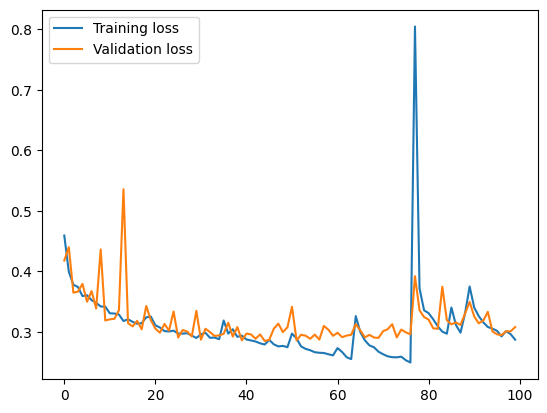

In [19]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error

model_combine_bce_iou.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_combine_bce_iou(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")

Mean Absolute Error: 102168.546875
IoU: 0.13897233966284306


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_combine_bce_iou = UNet(n_class=1).to(device)
model_combine_bce_iou.load_state_dict(torch.load("model.pth", map_location = device))

<All keys matched successfully>

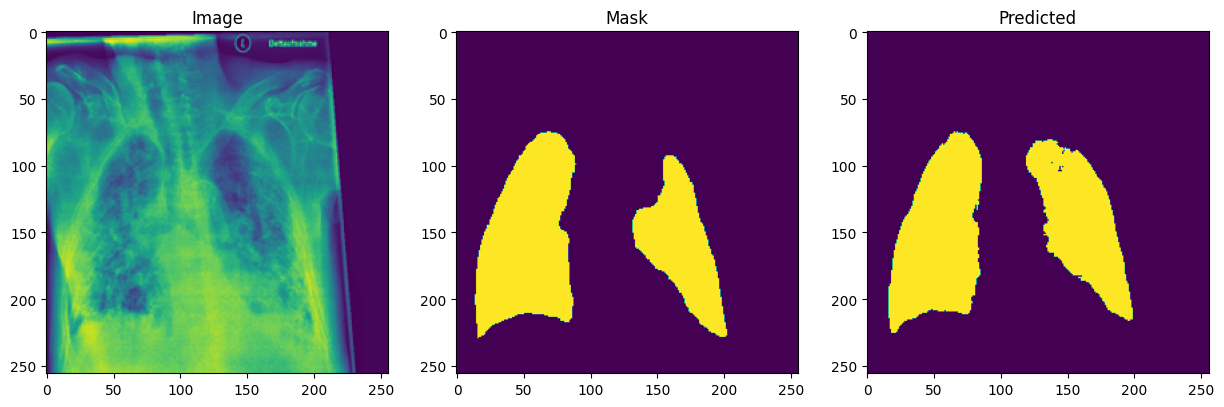

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


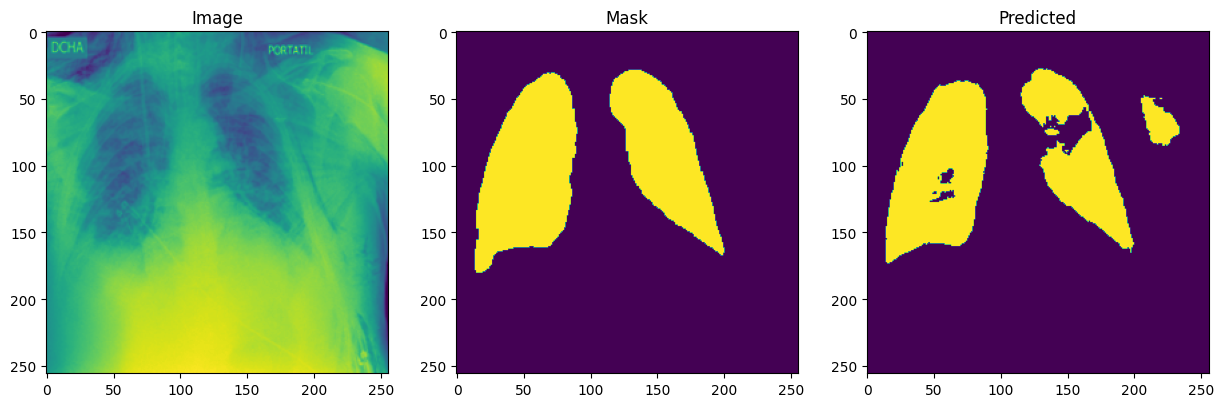

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


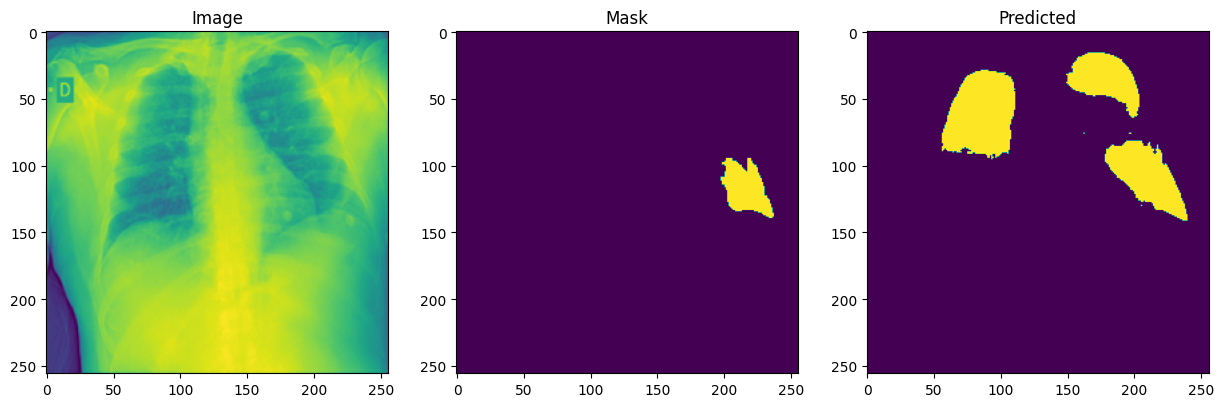

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


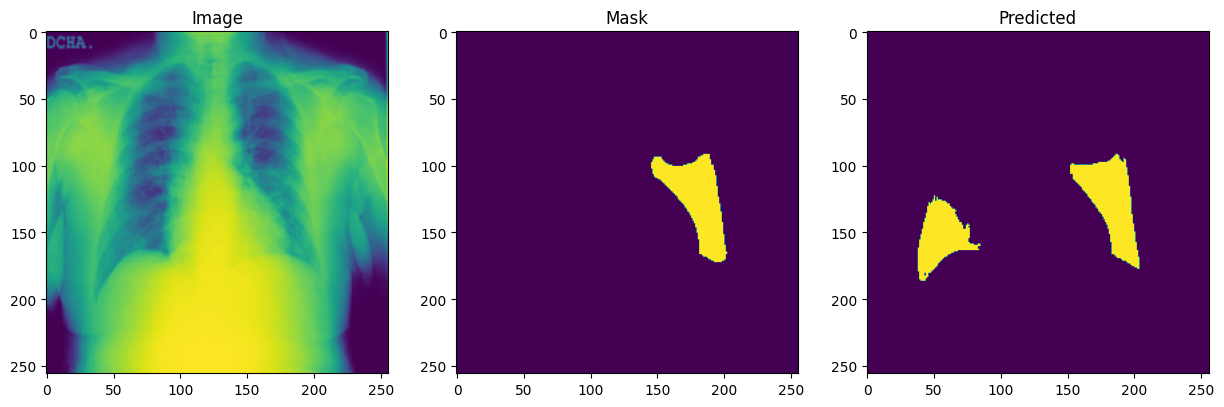

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


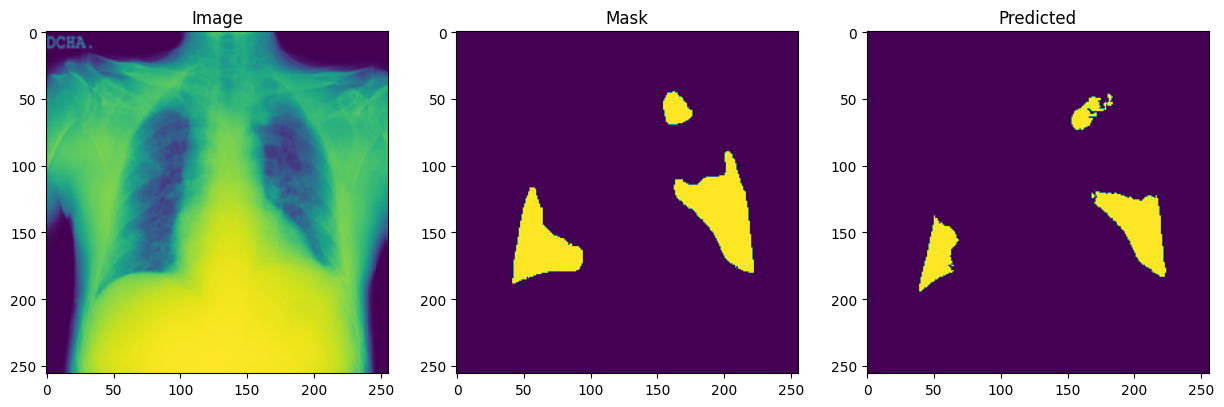

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


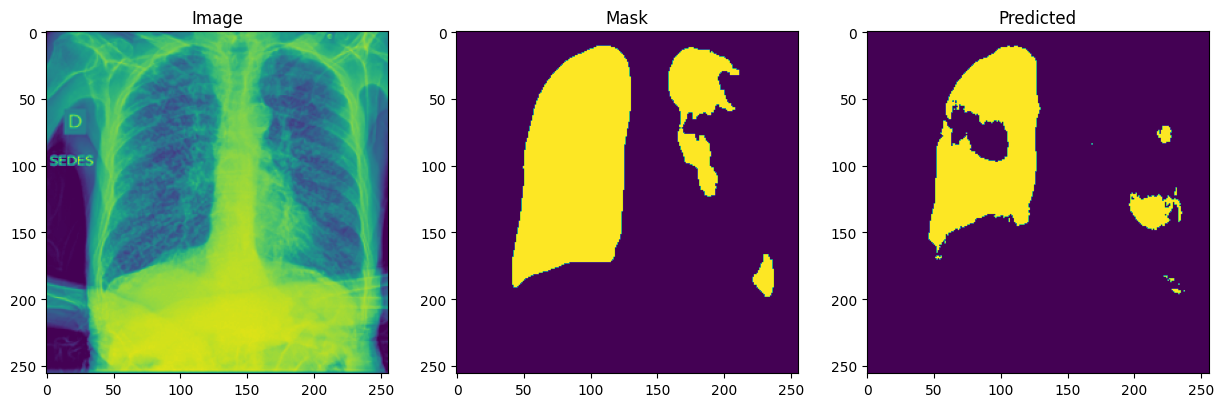

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


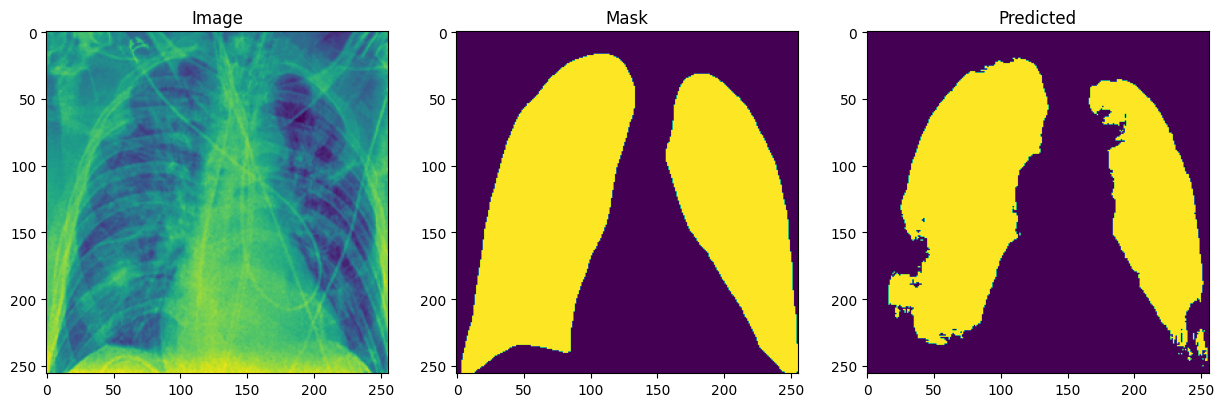

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


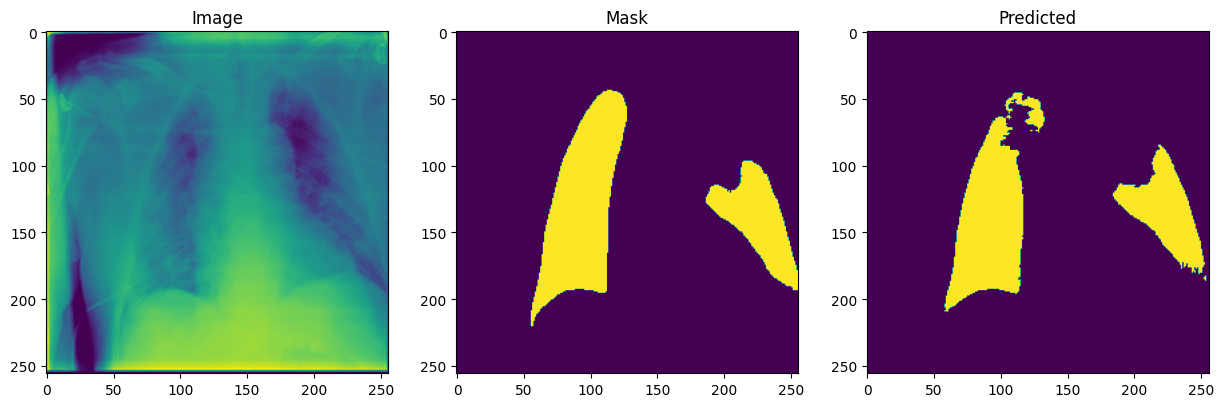

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


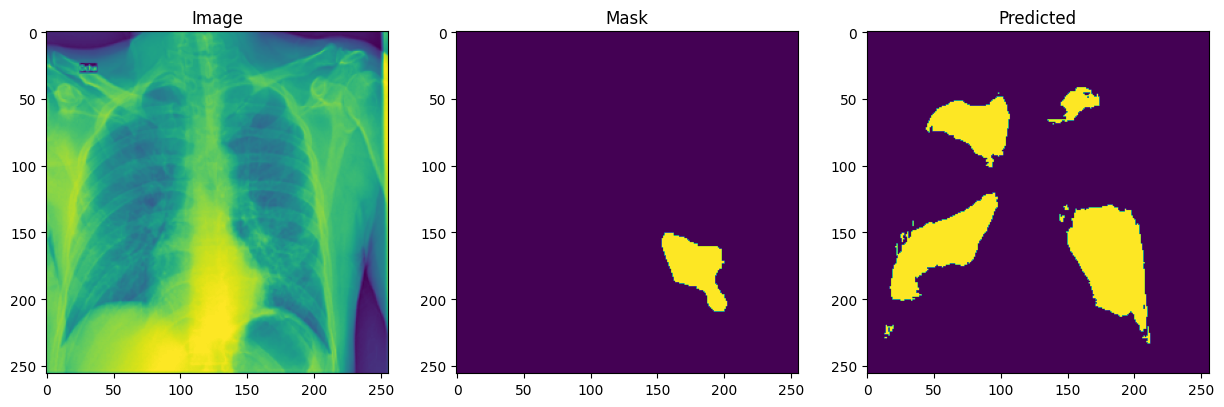

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


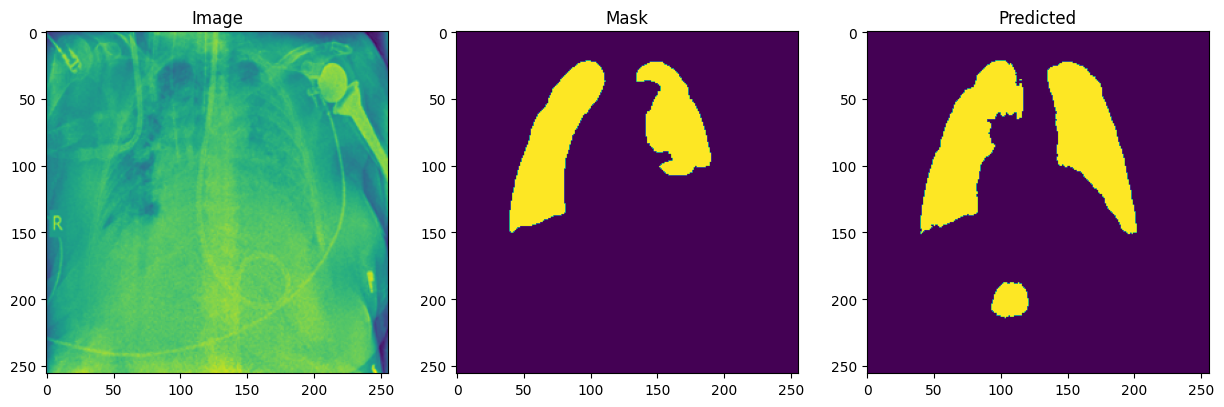

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
import matplotlib.pyplot as plt

for image_idx in range(100, 110):
    image, mask = test_dataset[image_idx]
    output = model_combine_bce_iou(image.unsqueeze(0).to(device)).to(device)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(image.permute(1, 2, 0))  # Display an image
    axs[0].set_title('Image')

    axs[1].imshow(mask[0])  # Display an image
    axs[1].set_title('Mask')

    axs[2].imshow(output[0, 0].cpu().detach().numpy()>0.15)  # Display an image
    axs[2].set_title('Predicted')

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


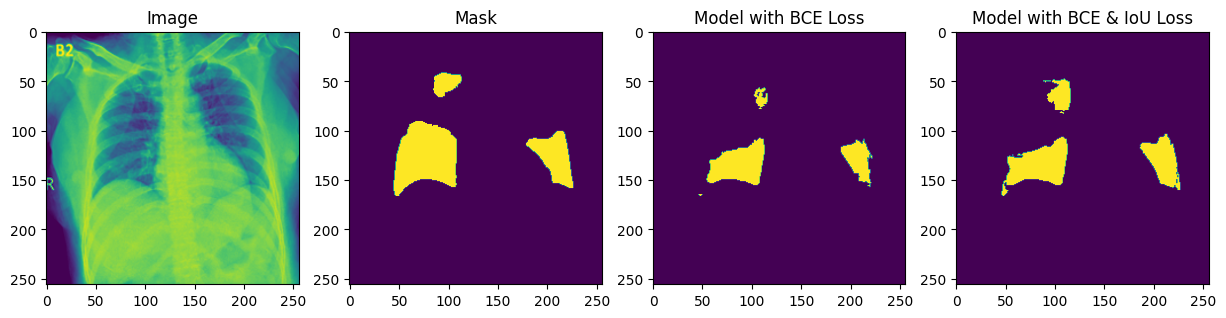

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


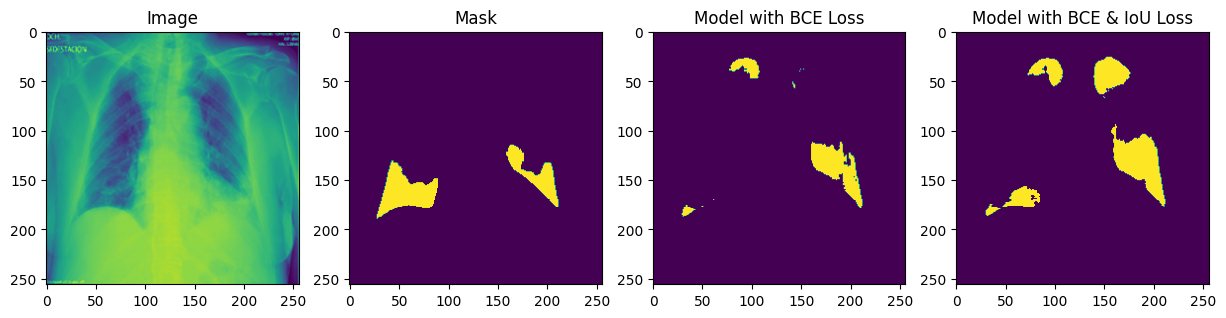

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


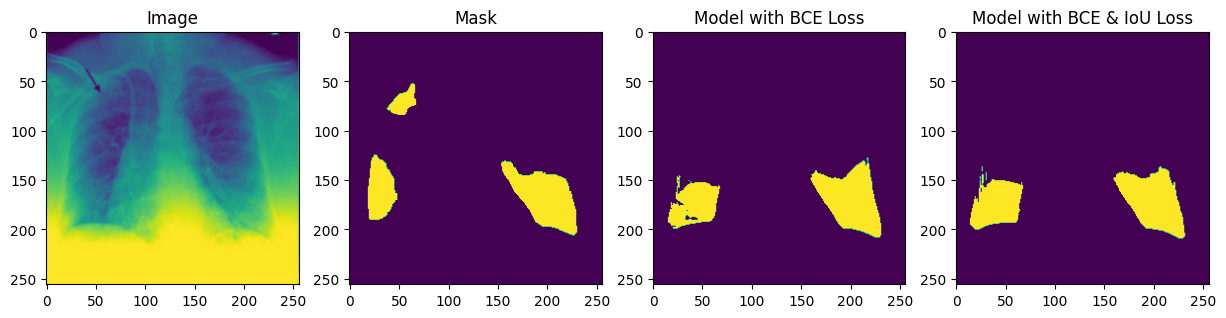

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


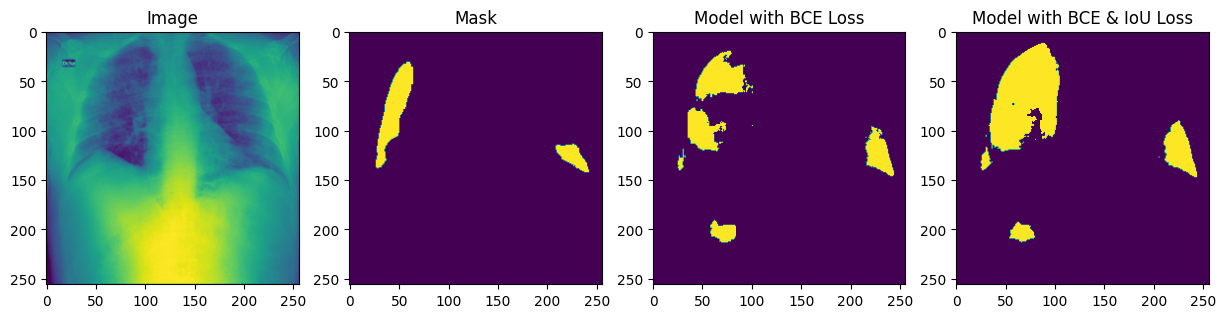

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


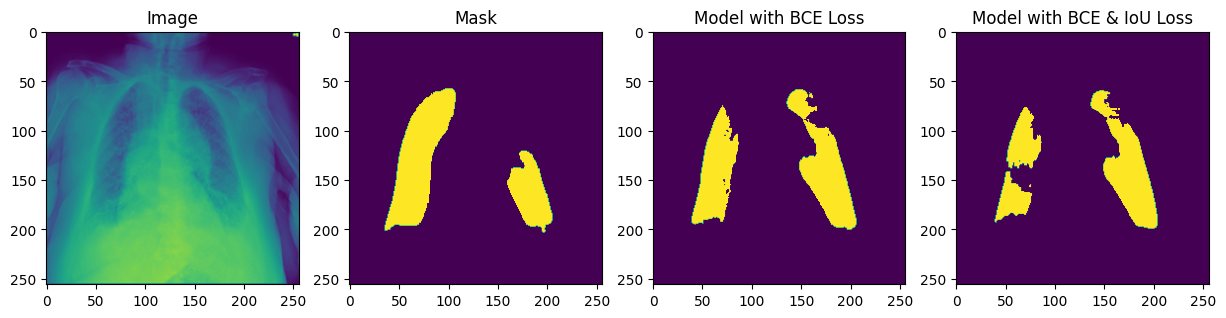

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


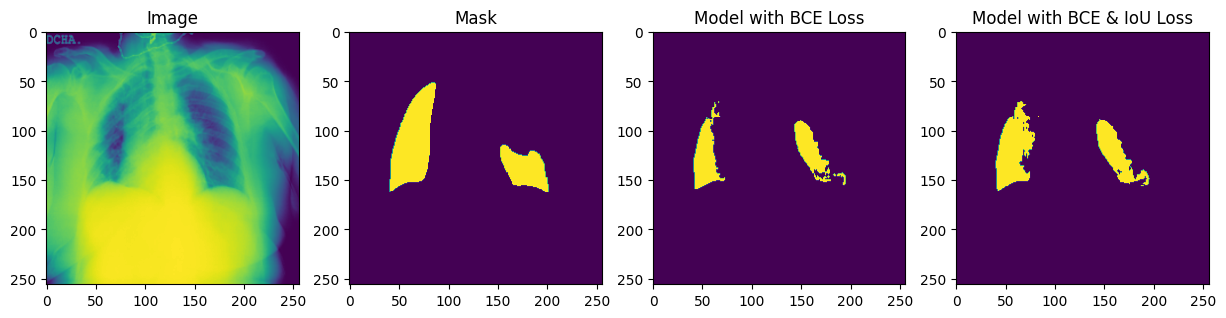

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


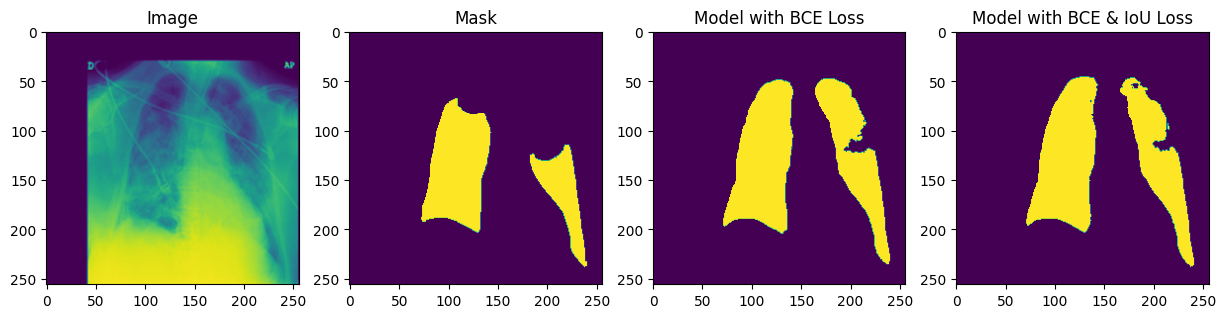

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


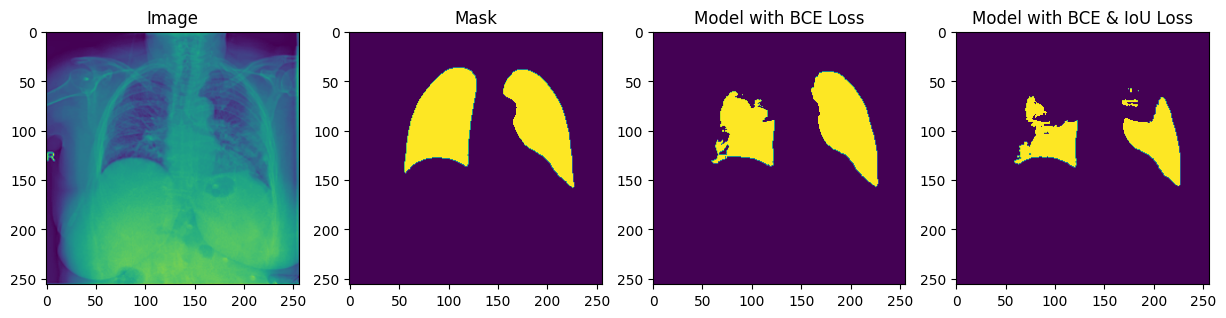

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


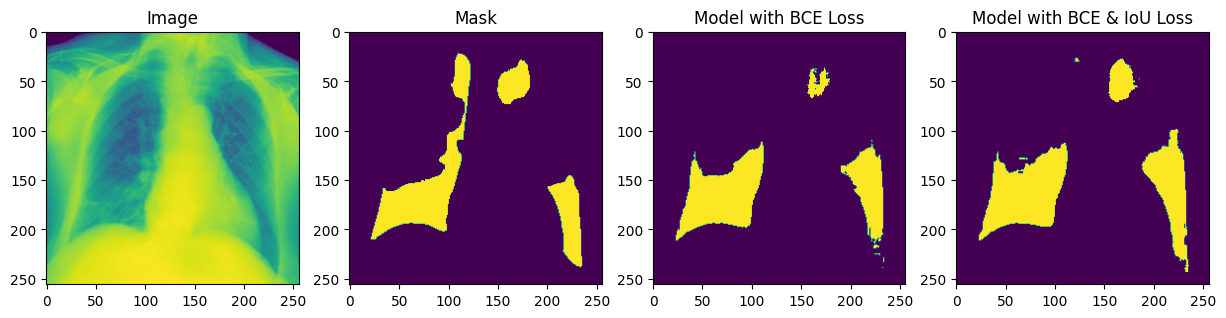

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


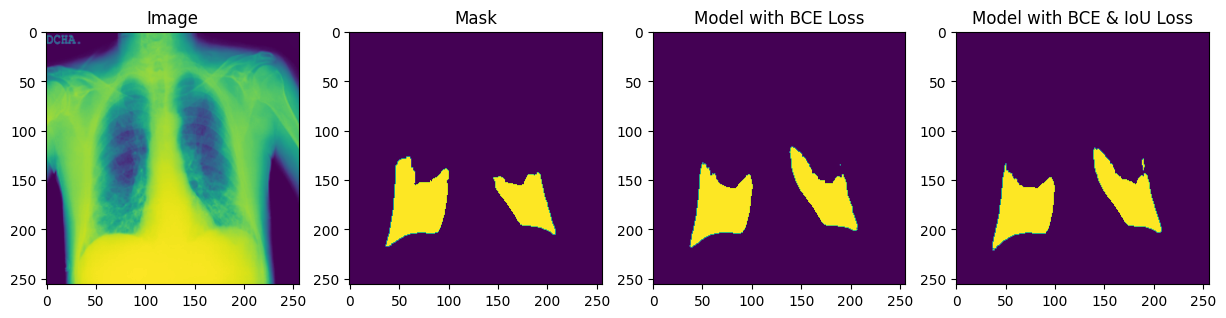

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


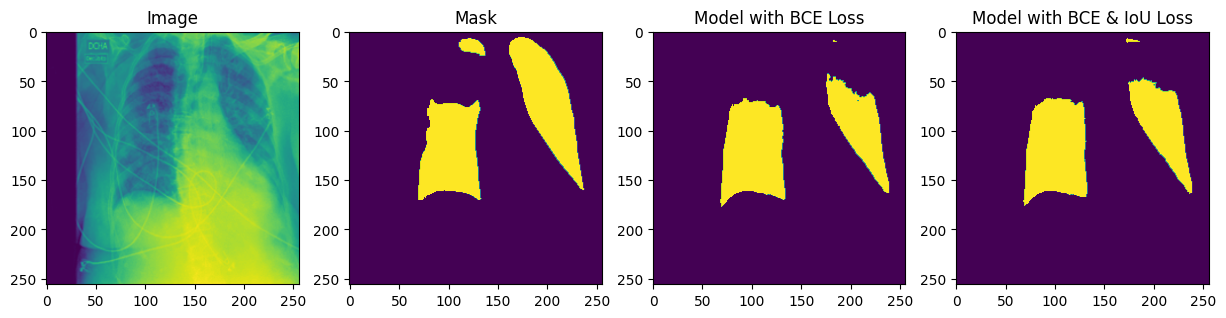

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


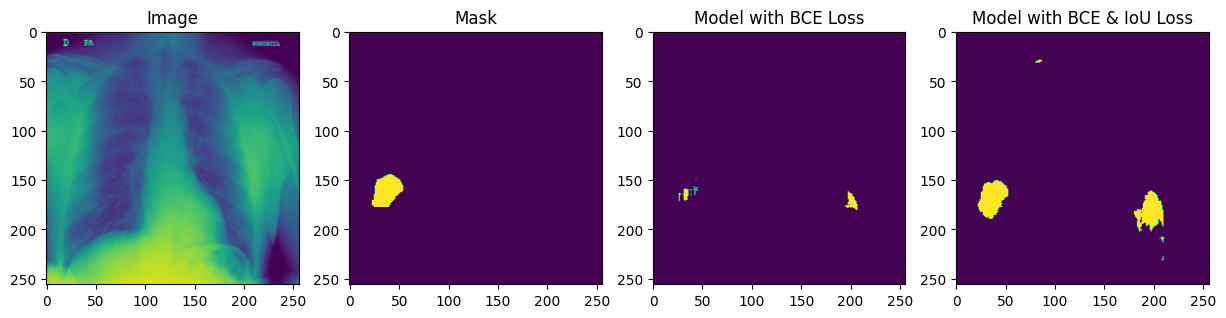

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


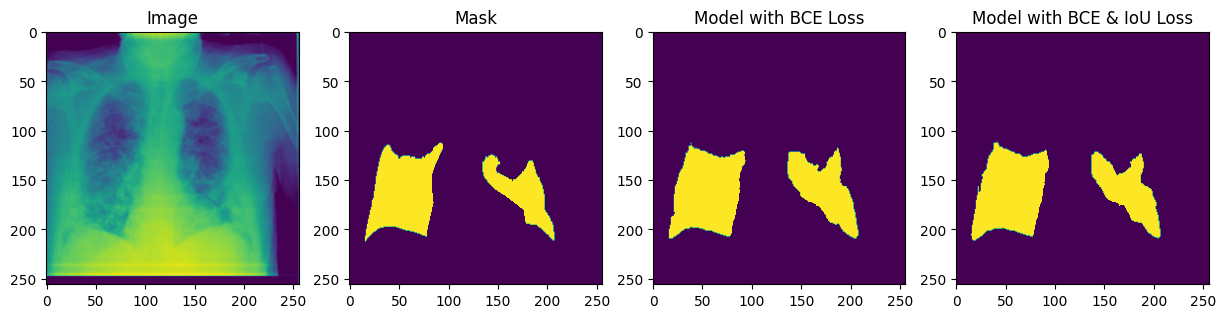

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


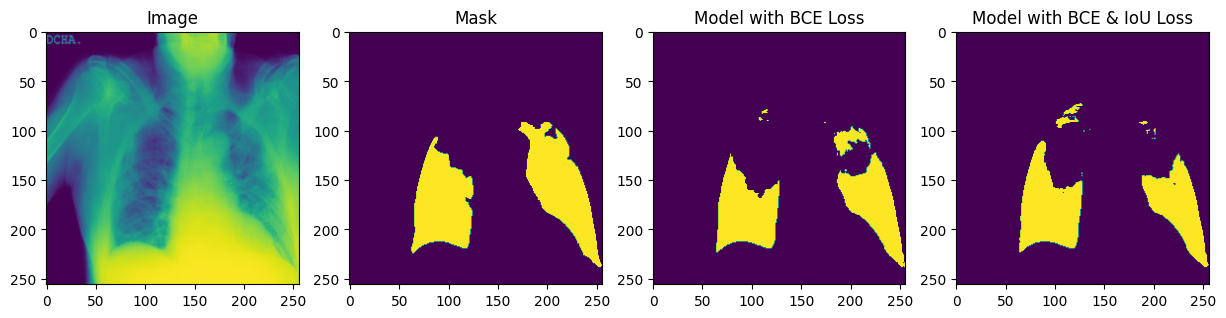

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


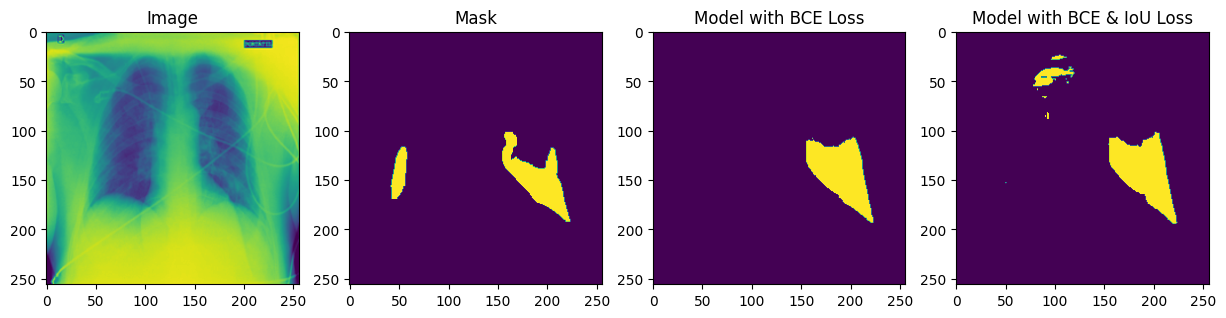

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


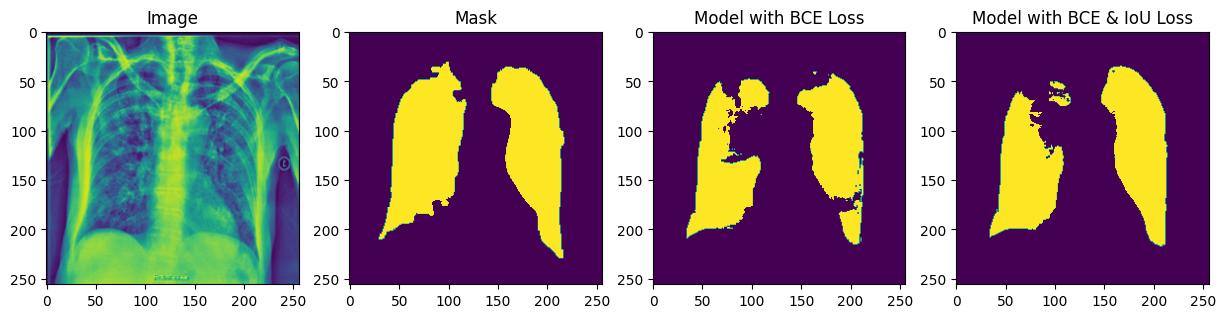

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


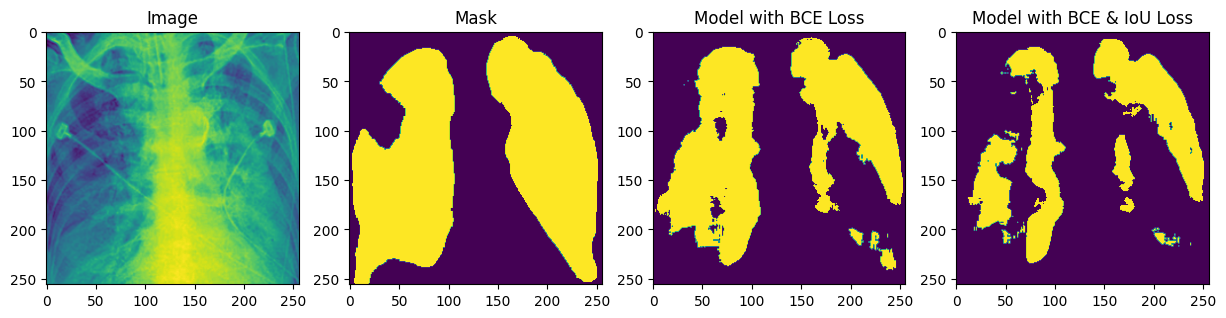

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


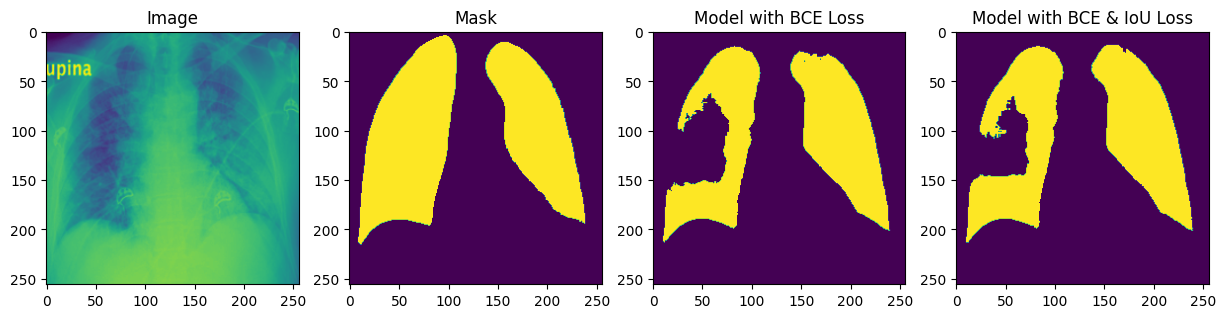

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


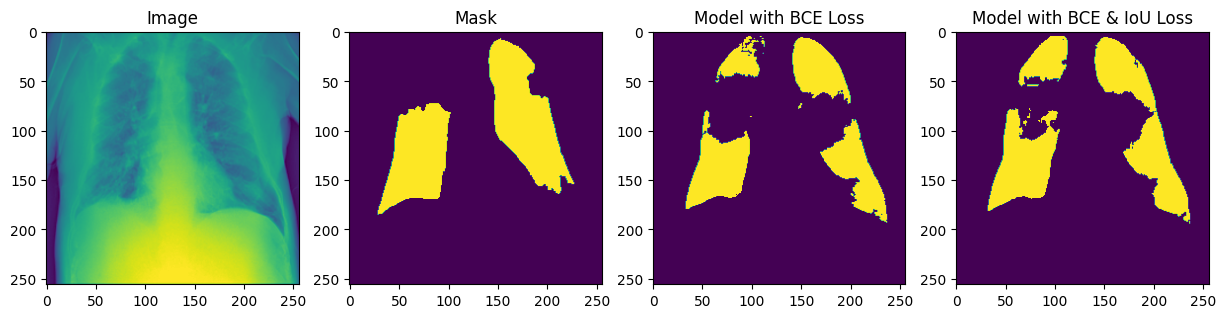

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


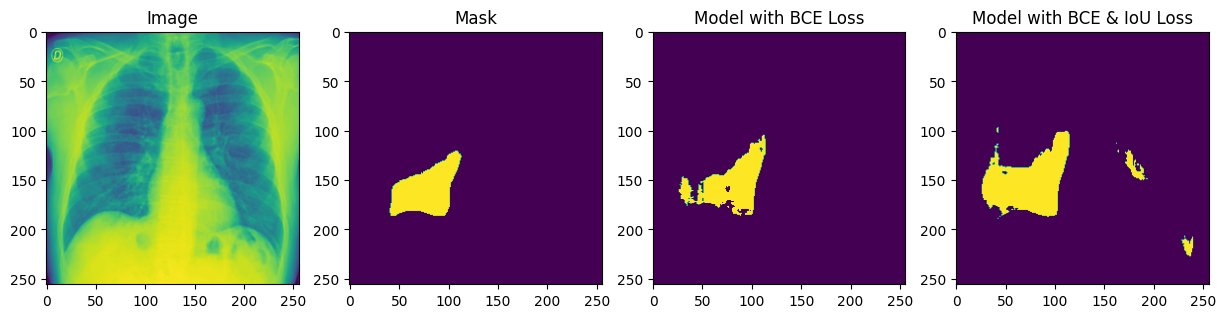

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [30]:
import matplotlib.pyplot as plt

for image_idx in range(180, 200):
    image, mask = test_dataset[image_idx]
    output = model(image.unsqueeze(0).to(device)).to(device)
    output_bce_iou = model_combine_bce_iou(image.unsqueeze(0).to(device)).to(device)
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(image.permute(1, 2, 0))  # Display an image
    axs[0].set_title('Image')

    axs[1].imshow(mask[0])  # Display an image
    axs[1].set_title('Mask')

    axs[2].imshow(output[0, 0].cpu().detach().numpy()>0.15)  # Display an image
    axs[2].set_title('Model with BCE Loss')
    
    axs[3].imshow(output_bce_iou[0, 0].cpu().detach().numpy()>0.05)  # Display an image
    axs[3].set_title('Model with BCE & IoU Loss')

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
